Related urls, will remove once finished:
- https://www.tensorflow.org/tutorials/structured_data/time_series#multi-step_models

In [28]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import itertools

In [29]:
file_path = "../data/parsed_dataset.csv"
date_column = "Date_reported"
target_column = "New_deaths"
df = pd.read_csv(file_path, parse_dates=True)
df = df[[date_column, target_column, "New_cases", "Cumulative_cases"]]
df = df.groupby(date_column).sum().reset_index()
df = df.dropna()
date_time = pd.to_datetime(df.pop(date_column), format="%Y-%m-%d")
df.set_index(date_time, inplace=True)

In [31]:
# Creating a data structure (it does not work when you have only one feature)
def create_data(
    df, n_future, n_past, train_test_split_percentage, validation_split_percentage
):
    n_feature = df.shape[1]
    x_data, y_data = [], []

    for i in range(n_past, len(df) - n_future + 1):
        x_data.append(df[i - n_past : i, 0:n_feature])
        y_data.append(df[i + n_future - 1 : i + n_future, 0])

    split_training_test_starting_point = int(
        round(train_test_split_percentage * len(x_data))
    )
    split_train_validation_starting_point = int(
        round(split_training_test_starting_point * (1 - validation_split_percentage))
    )

    x_train = x_data[:split_train_validation_starting_point]
    y_train = y_data[:split_train_validation_starting_point]

    # if you want to choose the validation set by yourself, uncomment the below code.
    x_val = x_data[
        split_train_validation_starting_point:split_training_test_starting_point
    ]
    y_val = x_data[
        split_train_validation_starting_point:split_training_test_starting_point
    ]

    x_test = x_data[split_training_test_starting_point:]
    y_test = y_data[split_training_test_starting_point:]

    return (
        np.array(x_train),
        np.array(x_test),
        np.array(x_val),
        np.array(y_train),
        np.array(y_test),
        np.array(y_val),
    )

In [65]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
scaled_data.shape

(1420, 3)

In [32]:
# Number of days you want to predict into the future
# Number of past days you want to use to predict the future

X_train, X_test, X_val, y_train, y_test, y_val = create_data(
    scaled_data,
    n_future=1,
    n_past=25,
    train_test_split_percentage=0.8,
    validation_split_percentage=0,
)

In [33]:
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(1116, 25, 3)
(279, 25, 3)
(1116, 1)
(279, 1)


In [34]:
# ------------------LSTM-----------------------
regressor = Sequential()
regressor.add(
    LSTM(
        units=16,
        return_sequences=True,
        input_shape=(X_train.shape[1], X_train.shape[2]),
    )
)
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=16, return_sequences=False))
regressor.add(Dropout(0.2))
regressor.add(Dense(units=1, activation="linear"))
regressor.compile(
    optimizer=tf.keras.optimizers.Adam(), loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

regressor.summary()

Model: "sequential_119"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_376 (LSTM)             (None, 25, 16)            1280      
                                                                 
 dropout_439 (Dropout)       (None, 25, 16)            0         
                                                                 
 lstm_377 (LSTM)             (None, 16)                2112      
                                                                 
 dropout_440 (Dropout)       (None, 16)                0         
                                                                 
 dense_119 (Dense)           (None, 1)                 17        
                                                                 
Total params: 3409 (13.32 KB)
Trainable params: 3409 (13.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [35]:
es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)
# mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# fit model
history = regressor.fit(
    X_train, y_train, validation_split=0.3, epochs=200, batch_size=64, callbacks=[es]
)

Epoch 1/200
13/13 [==============================] - 4s 82ms/step - loss: 0.8811 - root_mean_squared_error: 0.9386 - val_loss: 0.4964 - val_root_mean_squared_error: 0.7046
Epoch 2/200
13/13 [==============================] - 0s 21ms/step - loss: 0.5267 - root_mean_squared_error: 0.7257 - val_loss: 0.4456 - val_root_mean_squared_error: 0.6676
Epoch 3/200
13/13 [==============================] - 0s 20ms/step - loss: 0.4710 - root_mean_squared_error: 0.6863 - val_loss: 0.4788 - val_root_mean_squared_error: 0.6919
Epoch 4/200
13/13 [==============================] - 0s 21ms/step - loss: 0.4430 - root_mean_squared_error: 0.6656 - val_loss: 0.4469 - val_root_mean_squared_error: 0.6685
Epoch 5/200
13/13 [==============================] - 0s 21ms/step - loss: 0.4296 - root_mean_squared_error: 0.6554 - val_loss: 0.4073 - val_root_mean_squared_error: 0.6382
Epoch 6/200
13/13 [==============================] - 0s 21ms/step - loss: 0.4109 - root_mean_squared_error: 0.6410 - val_loss: 0.3869 - val_

In [36]:
history.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])

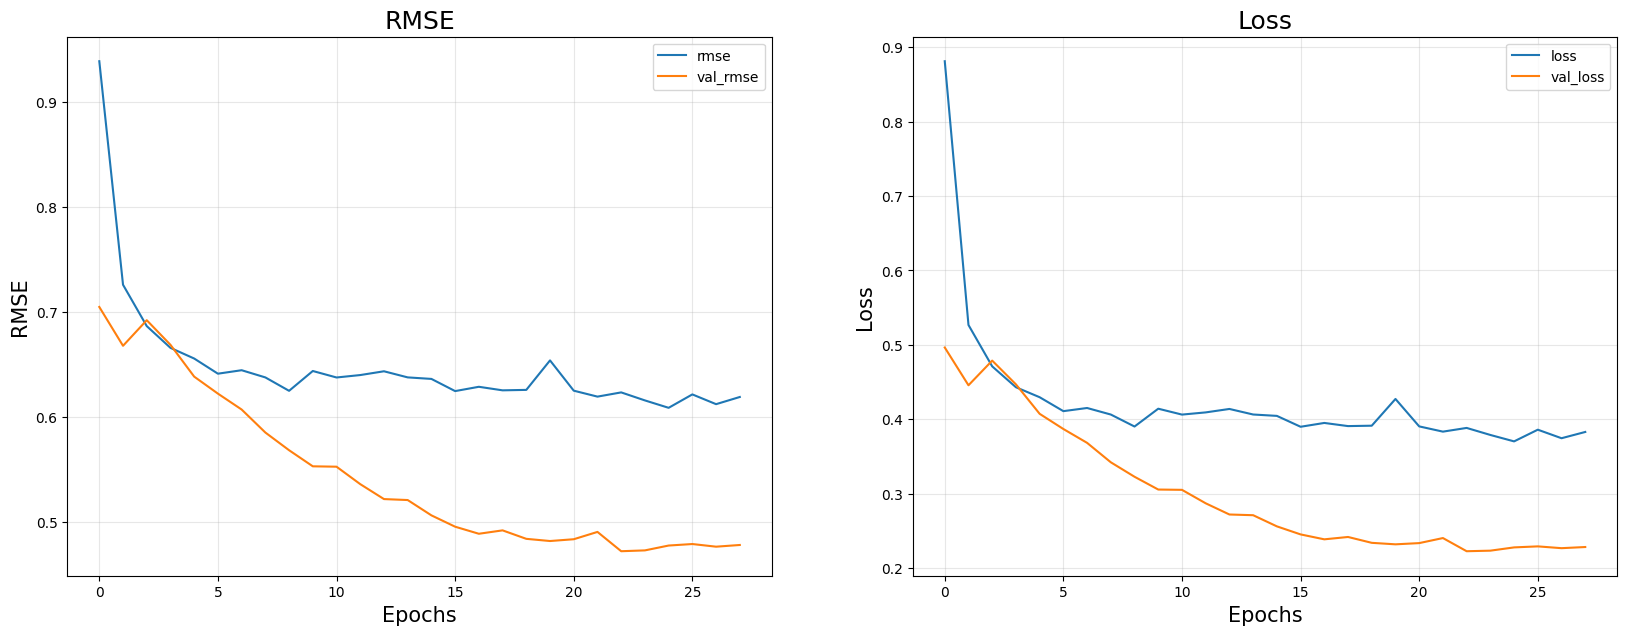

In [37]:
fig = plt.figure(figsize=(20, 7))
fig.add_subplot(121)

# Accuracy
plt.plot(history.epoch, history.history["root_mean_squared_error"], label="rmse")
plt.plot(
    history.epoch, history.history["val_root_mean_squared_error"], label="val_rmse"
)

plt.title("RMSE", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("RMSE", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()


# Adding Subplot 1 (For Loss)
fig.add_subplot(122)

plt.plot(history.epoch, history.history["loss"], label="loss")
plt.plot(history.epoch, history.history["val_loss"], label="val_loss")

plt.title("Loss", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

In [38]:
results = regressor.evaluate(X_test, y_test)
print("test loss, test acc:", np.round(results, 4))

9/9 [==============================] - 0s 4ms/step - loss: 0.4564 - root_mean_squared_error: 0.6756
test loss, test acc: [0.4564 0.6756]


In [39]:
# detect and init the TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)


def LSTM_HyperParameter_Tuning(config, x_train, y_train, x_test, y_test):
    (
        first_additional_layer,
        second_additional_layer,
        third_additional_layer,
        n_neurons,
        n_batch_size,
        dropout,
    ) = config
    possible_combinations = list(
        itertools.product(
            first_additional_layer,
            second_additional_layer,
            third_additional_layer,
            n_neurons,
            n_batch_size,
            dropout,
        )
    )

    print(possible_combinations)
    print("\n")

    hist = []

    for i in range(0, len(possible_combinations)):
        print(f"{i+1}th combination: \n")
        print("--------------------------------------------------------------------")

        (
            first_additional_layer,
            second_additional_layer,
            third_additional_layer,
            n_neurons,
            n_batch_size,
            dropout,
        ) = possible_combinations[i]

        # instantiating the model in the strategy scope creates the model on the TPU
        # with tpu_strategy.scope():
        regressor = Sequential()
        regressor.add(
            LSTM(
                units=n_neurons,
                return_sequences=True,
                input_shape=(x_train.shape[1], x_train.shape[2]),
            )
        )
        regressor.add(Dropout(dropout))

        if first_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if second_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if third_additional_layer:
            regressor.add(GRU(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        regressor.add(LSTM(units=n_neurons, return_sequences=False))
        regressor.add(Dropout(dropout))
        regressor.add(Dense(units=1, activation="linear"))
        regressor.compile(
            optimizer=tf.keras.optimizers.Adam(),
            loss="mse",
            metrics=[tf.keras.metrics.RootMeanSquaredError()],
        )

        es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)
        """''
        From the mentioned article above --> If a validation dataset is specified to the fit() function via the validation_data or v
        alidation_split arguments,then the loss on the validation dataset will be made available via the name “val_loss.”
        """ ""

        file_path = "best_model.h5"

        mc = ModelCheckpoint(
            file_path, monitor="val_loss", mode="min", verbose=1, save_best_only=True
        )

        """''
        cb = Callback(...)  # First, callbacks must be instantiated.
        cb_list = [cb, ...]  # Then, one or more callbacks that you intend to use must be added to a Python list.
        model.fit(..., callbacks=cb_list)  # Finally, the list of callbacks is provided to the callback argument when fitting the model.
        """ ""

        regressor.fit(
            x_train,
            y_train,
            validation_split=0.3,
            epochs=1000,
            batch_size=n_batch_size,
            callbacks=[es, mc],
            verbose=0,
        )

        # load the best model
        # regressor = load_model('best_model.h5')

        train_accuracy = regressor.evaluate(x_train, y_train, verbose=0)
        test_accuracy = regressor.evaluate(x_test, y_test, verbose=0)

        hist.append(
            list(
                (
                    first_additional_layer,
                    second_additional_layer,
                    third_additional_layer,
                    n_neurons,
                    n_batch_size,
                    dropout,
                    train_accuracy,
                    test_accuracy,
                )
            )
        )

        print(
            f"{str(i)}-th combination = {possible_combinations[i]} \n train accuracy: {train_accuracy} and test accuracy: {test_accuracy}"
        )

    return hist

In [40]:
config = [
    [True, False],
    [True, False],
    [True, False],
    [64, 128, 256],
    [7, 28,365],
    [0.2],
]

# list of lists --> [[first_additional_layer], [second_additional_layer], [third_additional_layer], [n_neurons], [n_batch_size], [dropout]]

hist = LSTM_HyperParameter_Tuning(
    config, X_train, y_train, X_test, y_test
)  # change x_train shape

[(True, True, True, 64, 7, 0.2), (True, True, True, 64, 28, 0.2), (True, True, True, 64, 365, 0.2), (True, True, True, 128, 7, 0.2), (True, True, True, 128, 28, 0.2), (True, True, True, 128, 365, 0.2), (True, True, True, 256, 7, 0.2), (True, True, True, 256, 28, 0.2), (True, True, True, 256, 365, 0.2), (True, True, False, 64, 7, 0.2), (True, True, False, 64, 28, 0.2), (True, True, False, 64, 365, 0.2), (True, True, False, 128, 7, 0.2), (True, True, False, 128, 28, 0.2), (True, True, False, 128, 365, 0.2), (True, True, False, 256, 7, 0.2), (True, True, False, 256, 28, 0.2), (True, True, False, 256, 365, 0.2), (True, False, True, 64, 7, 0.2), (True, False, True, 64, 28, 0.2), (True, False, True, 64, 365, 0.2), (True, False, True, 128, 7, 0.2), (True, False, True, 128, 28, 0.2), (True, False, True, 128, 365, 0.2), (True, False, True, 256, 7, 0.2), (True, False, True, 256, 28, 0.2), (True, False, True, 256, 365, 0.2), (True, False, False, 64, 7, 0.2), (True, False, False, 64, 28, 0.2), (Tr

/home/samuell/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss did not improve from 0.11791

Epoch 3: val_loss did not improve from 0.11791

Epoch 4: val_loss did not improve from 0.11791

Epoch 5: val_loss did not improve from 0.11791

Epoch 6: val_loss did not improve from 0.11791
Epoch 6: early stopping
0-th combination = (True, True, True, 64, 7, 0.2) 
 train accuracy: [0.29347604513168335, 0.5417342782020569] and test accuracy: [0.048044804483652115, 0.21919125318527222]
2th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 0.25740, saving model to best_model.h5

Epoch 2: val_loss improved from 0.25740 to 0.17916, saving model to best_model.h5

Epoch 3: val_loss improved from 0.17916 to 0.12498, saving model to best_model.h5

Epoch 4: val_loss improved from 0.12498 to 0.12488, saving model to best_model.h5

Epoch 5: val_loss did not improve from 0.12488

Epoch 6: val_loss did not improve from 0.12488

Epoch 7: val_loss improved from 0.12488 to 0.12080

In [41]:
hist = pd.DataFrame(hist)
hist = hist.sort_values(by=[7], ascending=True)
hist

,0,1,2,3,4,5,6,7
42,False,True,True,256,7,0.2,"[0.20050184428691864, 0.44777432084083557]","[0.014851296320557594, 0.1218658983707428]"
9,True,True,False,64,7,0.2,"[0.11247485876083374, 0.3353727161884308]","[0.015611509792506695, 0.12494602799415588]"
66,False,False,False,128,7,0.2,"[0.22997918725013733, 0.479561448097229]","[0.016098905354738235, 0.1268814653158188]"
57,False,False,True,128,7,0.2,"[0.201826810836792, 0.4492513835430145]","[0.016758758574724197, 0.12945562601089478]"
39,False,True,True,128,7,0.2,"[0.19044435024261475, 0.43639931082725525]","[0.016869014129042625, 0.12988077104091644]"
...,...,...,...,...,...,...,...,...
43,False,True,True,256,28,0.2,"[0.3122140169143677, 0.5587611198425293]","[0.18701744079589844, 0.4324551224708557]"
34,True,False,False,256,28,0.2,"[0.32176920771598816, 0.5672470331192017]","[0.2081863433122635, 0.4562744200229645]"
51,False,True,False,256,7,0.2,"[0.28312402963638306, 0.5320940017700195]","[0.2123878002166748, 0.46085551381111145]"
38,False,True,True,64,365,0.2,"[0.3413187563419342, 0.5842249393463135]","[0.2199704647064209, 0.4690100848674774]"


In [42]:
print(
    f"Best Combination: \n first_additional_layer = {hist.iloc[0, 0]}\n second_additional_layer = {hist.iloc[0, 1]}\n third_additional_layer = {hist.iloc[0, 2]}\n n_neurons = {hist.iloc[0, 3]}\n n_batch_size = {hist.iloc[0, 4]}\n dropout = {hist.iloc[0, 5]}"
)
print("**************************")
print(f"Results Before Tunning:\n Test Set RMSE: {np.round(results, 4)[1]}\n")
print(f"Results After Tunning:\n Test Set RMSE: {np.round(hist.iloc[0, -1], 4)[1]}\n")
print(
    f"{np.round((results[1] - hist.iloc[0, -1][1])*100/np.round(results, 4)[1])}% Improvement"
)

Best Combination: 
 first_additional_layer = False
 second_additional_layer = True
 third_additional_layer = True
 n_neurons = 256
 n_batch_size = 7
 dropout = 0.2
**************************
Results Before Tunning:
 Test Set RMSE: 0.6756

Results After Tunning:
 Test Set RMSE: 0.1219

82.0% Improvement


In [43]:
(
    first_additional_layer,
    second_additional_layer,
    third_additional_layer,
    n_neurons,
    n_batch_size,
    dropout,
) = list(hist.iloc[0, :-2])

In [44]:
regressor = Sequential()
regressor.add(
    LSTM(
        units=n_neurons,
        return_sequences=True,
        input_shape=(X_train.shape[1], X_train.shape[2]),
    )
)
regressor.add(Dropout(dropout))

if first_additional_layer:
    regressor.add(LSTM(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

if second_additional_layer:
    regressor.add(LSTM(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

if third_additional_layer:
    regressor.add(GRU(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

regressor.add(LSTM(units=n_neurons, return_sequences=False))
regressor.add(Dropout(dropout))
regressor.add(Dense(units=1, activation="linear"))
regressor.compile(optimizer=tf.keras.optimizers.Adam(), loss="mse")

es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)

file_path = "best_model.h5"

mc = ModelCheckpoint(
    file_path, monitor="val_loss", mode="min", verbose=1, save_best_only=True
)

regressor.fit(
    X_train,
    y_train,
    validation_split=0.3,
    epochs=200,
    batch_size=n_batch_size,
    callbacks=[es, mc],
    verbose=0,
)


Epoch 1: val_loss improved from inf to 0.21969, saving model to best_model.h5


/home/samuell/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 0.21969 to 0.15643, saving model to best_model.h5

Epoch 3: val_loss improved from 0.15643 to 0.15364, saving model to best_model.h5

Epoch 4: val_loss did not improve from 0.15364

Epoch 5: val_loss did not improve from 0.15364

Epoch 6: val_loss did not improve from 0.15364

Epoch 7: val_loss did not improve from 0.15364

Epoch 8: val_loss improved from 0.15364 to 0.13443, saving model to best_model.h5

Epoch 9: val_loss did not improve from 0.13443

Epoch 10: val_loss did not improve from 0.13443

Epoch 11: val_loss did not improve from 0.13443

Epoch 12: val_loss did not improve from 0.13443

Epoch 13: val_loss did not improve from 0.13443
Epoch 13: early stopping


In [45]:
regressor.evaluate(X_test, y_test)

9/9 [==============================] - 0s 45ms/step - loss: 0.0488


0.04877952113747597

In [72]:
y_pred = regressor.predict(X_test)

9/9 [==============================] - 0s 45ms/step


array([-0.3039157 , -0.87533997, -0.62814479, -0.96331742, -0.95881126,
       -0.94357614, -0.94894062, -0.89315004, -0.31957998, -0.64595486,
       -0.95816752, -0.96052789, -0.94421987, -0.93606587, -0.9326326 ,
       -0.40669911, -0.69959965, -0.94958435, -0.97125685, -0.95451967,
       -0.94872604, -0.96460489, -0.4890975 , -0.70238918, -0.89508125,
       -0.95881126, -0.9470094 , -0.96889648, -0.95516341, -0.52836549,
       -0.66633988, -0.90216236, -0.96181536, -0.95688004, -0.94958435,
       -0.97125685, -0.48544966, -0.67385015, -0.95173014, -0.97576301,
       -0.96675068, -0.90066031, -0.95280304, -0.56505852, -0.72835325,
       -0.96846732, -1.00001045, -0.98692112, -0.97039853, -0.99636261,
       -0.9768359 , -0.23203169, -0.96610695, -0.9974355 , -0.97232974,
       -0.98456075, -0.98456075, -0.9727589 , -0.33867752, -0.96224452,
       -0.9922856 , -0.98756486, -0.97297348, -0.98756486, -0.99464597,
       -0.31228429, -0.95795294, -0.99164187, -0.99142729, -0.99

9/9 [==============================] - 0s 44ms/step
[3968.27485903 5375.36662443 3101.19375925 2103.217681   2011.15927734
 2224.93158271 1989.13035973 1347.73650005 2987.72684763 2969.60983024
 1456.85221086 1350.40952539 1723.34558685 1754.0163512  1515.69237897
 3335.56958168 4507.04612893 2355.27233134 1602.4041764  1607.19939997
 1609.34048687 1348.97731936 1910.55874804 3429.36282683 2217.56305491
 1439.76240408 1356.85834137 1409.22608265 1336.03357681 1743.6009134
 3093.82439812 2357.3481412  1522.17286125 1349.87953138 1379.68752771
 1323.49871852 1676.55139367 2768.84571114 2178.7554381  1493.86234799
 1355.32641424 1357.06139463 1322.28539891 1821.91475023 2668.31740324
 2030.47072568 1436.92076954 1311.93857144 1305.61336518 1315.96213706
 1914.6520351  3099.90669047 1851.05497633 1179.66534467 1206.41837554
 1402.16366249 1388.84214644 1662.58794042 3900.28347495 3205.33188745
 1752.82164249 1347.10872937 1387.40744043 1335.69941392 1257.52585329
 2580.51672922 2813.101599

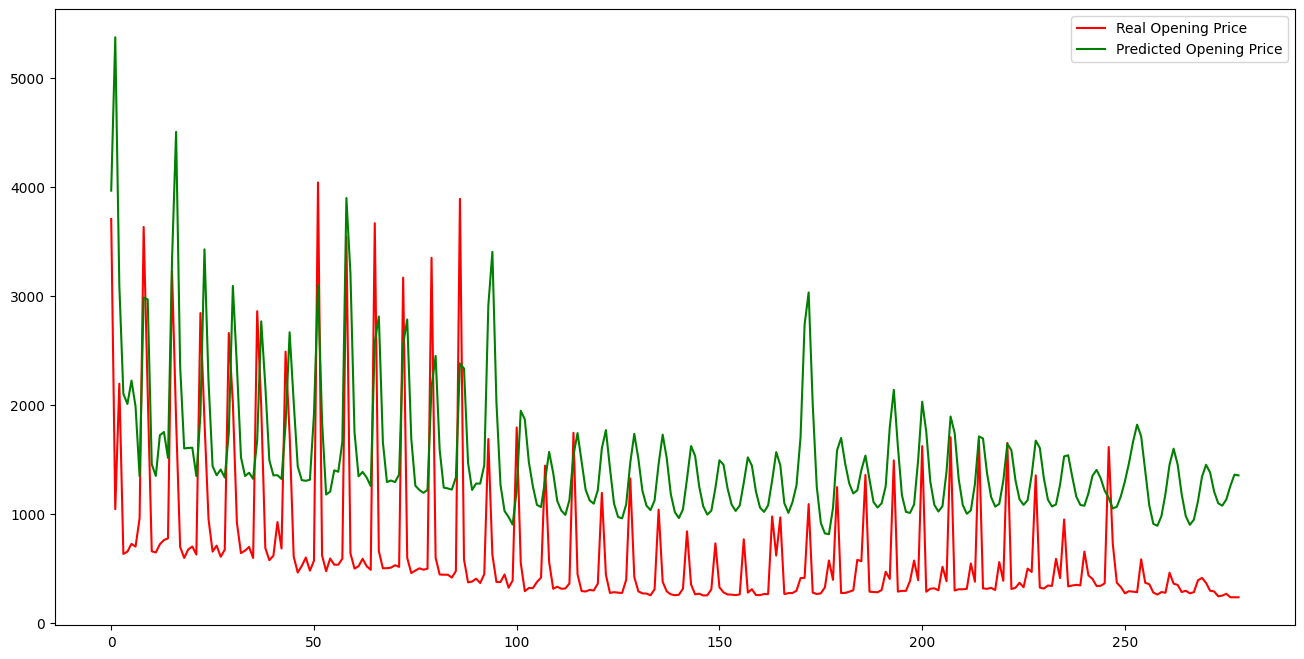

In [73]:
scaler = StandardScaler()
scaler.fit(df[[target_column]])
y_pred = regressor.predict(X_test)
unscaled_y_pred = scaler.inverse_transform([y_pred.flatten()])[0]
unscaled_y_test = scaler.inverse_transform([y_test.flatten()])[0]
print(unscaled_y_pred)
plt.figure(figsize=(16, 8), dpi=100, facecolor="w", edgecolor="k")

plt.plot(unscaled_y_test, color="red", label="Real Opening Price")
plt.plot(unscaled_y_pred, color="green", label="Predicted Opening Price")
plt.legend(loc="best")

In [74]:
from metrics import print_evaluation_metrics
print_evaluation_metrics(unscaled_y_pred, unscaled_y_test)


Evaluation Metrics:
MSE: 1059406.22
RMSE: 1029.27
MAE: 929.24
MAPE: 221.03
SMAPE: 95.31
